In [1]:
# JM: 22 May 2021
# scrap notebook to test turning qgm2 data into eddy force function data through FEniCS

from dolfin import *
from qgm2_parameters import *

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import xarray as xr
from numba import jit
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import interpolate

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["mathtext.rm"] = "serif"
plt.rcParams["image.cmap"] = "RdBu_r"
plt.rcParams["axes.formatter.limits"] = [-4, 4]
plt.rcParams["font.size"] = 12.0

ntau=80
data_dir = "../data/outputs/"

finished loading qgm2_parameters


In [2]:
# set up mesh
import matplotlib.tri as tri

mesh = RectangleMesh(Point(0.0, 0.0), Point(L, L), ngrid, ngrid)
space = FunctionSpace(mesh, "CG", 1)
test, trial = TestFunction(space), TrialFunction(space)
zero_bcs = DirichletBC(space, 0.0, "on_boundary")

# some general reusable variables
x_vec, y_vec = np.meshgrid(np.linspace(0, L, ngrid+1), np.linspace(0, L, ngrid+1))
input_points = np.array([x_vec[:].flatten(), y_vec[:].flatten()]).T
output_points = mesh.coordinates()
triang = tri.Triangulation(output_points[:, 0], output_points[:, 1])

# for putting stuff onto mesh
dof_2_vert = dof_to_vertex_map(space)

# for moving stuff onto grid
vert_2_dof = vertex_to_dof_map(space)

In [3]:
# interpolate a function onto the mesh
# FORNOW: do this with eddy PV flux to test eddy force function

# load (non-dimensional) binary data
#   if "*_int.dat", remember to divide by the (non-dim) stime to turn into t_avg data

#TODO: consider defining a class and imbuing this as a subroutine

def load_grid_data(data_dir, filename, layers=layers, tave=False):
    """tidy-up subroutine to load the grid data"""
    grid_data = np.fromfile(data_dir + filename, dtype=np.float64).reshape(layers, ngrid+1, ngrid+1)
    if tave:
        grid_data /= stime
    
    return grid_data

def grid_to_mesh(grid_data, mesh_func):
    """Takes grid data and interpolates it onto a pre-defined finite element mesh"""
    for layer in range(len(mesh_func)):
        data_in = grid_data[layer,:,:]

        # interpolator = interpolate.LinearNDInterpolator(input_points, data_in[:].flatten())
        interpolator = interpolate.NearestNDInterpolator(input_points, data_in[:].flatten())  # much faster
        mesh_func[layer].vector()[:] = interpolator(output_points[dof_2_vert])
        
    return mesh_func

def mesh_to_grid(mesh_func, ny=ngrid+1, nx=ngrid+1):
    """Takes finite element function and pull out data onto regular grid
    
       This subtroutine exploits the fact that the mesh is structued and regular, so just do it
       with vertex_to_dof map. If not regular mesh, will need to write a probing routine,
       or cheat by pulling out vertices then constructing an interpolator.
    """
    layers = len(mesh_func)
    grid_data = np.zeros((layers, ny, nx))
    for l in range(layers):
        grid_data[l, :, :] = np.reshape(mesh_func[l].vector()[vert_2_dof], (ngrid+1, ngrid+1))
        
    return grid_data

In [4]:
# a slower version of James' flux calculator class without using caching from timestepping module

import ufl

class FluxCalculator(object):
    def __init__(self, space, H, s):
        
        """ Imbue object with attributes"""
        
        self.__space  = space
        self.__H      = H
        self.__s      = s
        self.__layers = len(H)
        
        layers = len(H) # local variable for looping
        
        # Stratification
        smat = np.zeros((layers, layers))
        if layers > 1:
            smat[0, 0]   = -float(s[0][1])
            smat[0, 1]   = +float(s[0][1])
            smat[-1, -2] = +float(s[-1][0])
            smat[-1, -1] = -float(s[-1][0])
            for i in range(1, layers - 1):
                smat[i, i - 1] = +float(s[i][0])
                smat[i, i]     = -(float(s[i][0]) + float(s[i][1]))
                smat[i, i + 1] = +float(s[i][1])
        ss, modes_to_z = np.linalg.eig(smat)
        z_to_modes = np.linalg.inv(modes_to_z)
        blayer = 0;  mss = abs(ss[0])
        for i in range(1, len(ss)):
            if abs(ss[i]) < mss:
                blayer = i
                mss = abs(ss[i])
        assert(mss < 1.0e-12)
        ss = [Constant(ss[i]) for i in range(layers)]
        
        self.__ss = ss
        self.__z_to_modes = z_to_modes
        self.__modes_to_z = modes_to_z
    
        self.__space = FunctionSpace(space.mesh(), "CG", 1)
        self.__test, self.__trial = TestFunction(self.__space), TrialFunction(self.__space)
        self.__zero_bcs = DirichletBC(self.__space, 0.0, "on_boundary")
        
        a = inner(self.__test, self.__trial) * dx
        self.__M = assemble(a)
    
        return
    
    def T_c(self, psi, return_K = False):
        
        """Compute mean part to obtain for eddy part later"""
        M = [Function(self.__space, name = "M_%i" % (i + 1)) for i in range(self.__layers)]
        N = [Function(self.__space, name = "N_%i" % (i + 1)) for i in range(self.__layers)]
        P = [Function(self.__space, name = "P_%i" % (i + 1)) for i in range(self.__layers)]
        
        if return_K:
            K = [Function(self.__space, name = "K_%i" % (i + 1)) for i in range(self.__layers)]
        
        print(f"computing mean fluxes at")
        
        for l in range(self.__layers):
            print(f"  layer {l+1}...")
            
            grad_psi = grad(psi[l])
            psi_x, psi_y = grad_psi
            u, v = -psi_y, psi_x
            
            b = assemble(inner(self.__test, 0.5 * (v * v - u * u)) * dx)
            solve(self.__M, M[l].vector(), b)
            
            b = assemble(inner(self.__test, u * v) * dx)
            solve(self.__M, N[l].vector(), b)
            
            P_l = ufl.algebra.Zero()
            if l > 0:
                P_l += 0.25 * self.__s[l][0] * ((psi[l - 1] - psi[l]) ** 2)
            if l < self.__layers - 1:
                P_l += 0.25 * self.__s[l][1] * ((psi[l + 1] - psi[l]) ** 2)
            b = assemble(inner(self.__test, P_l) * dx)
            solve(self.__M, P[l].vector(), b)
            
            if return_K:
                b = assemble(inner(self.__test, 0.5 * (v * v + u * u)) * dx)
                solve(self.__M, K[l].vector(), b)
            
        R = [Function(self.__space, name = "R_%i" % (i + 1)) for i in range(self.__layers - 1)]
        S = [Function(self.__space, name = "S_%i" % (i + 1)) for i in range(self.__layers - 1)]
        
        if return_K:
            K_i = [Function(self.__space, name = "K_i_%i" % (i + 1)) for i in range(self.__layers - 1)]
            P_i = [Function(self.__space, name = "P_i_%i" % (i + 1)) for i in range(self.__layers - 1)]

        for l in range(self.__layers - 1):
            print(f"  at interface {l+3/2}...")
            
            grad_psi_l = grad(psi[l])
            psi_l_x, psi_l_y = grad_psi_l
            grad_psi_lp1 = grad(psi[l + 1])
            psi_lp1_x, psi_lp1_y = grad_psi_lp1
            u, v = 0.5 * (-psi_l_y - psi_lp1_y), 0.5 * (psi_l_x + psi_lp1_x)

            b = assemble(inner(self.__test, u * self.__H[l] * self.__s[l][1] * (psi[l] - psi[l + 1])) * dx)
            solve(self.__M, R[l].vector(), b)

            b = assemble(inner(self.__test, v * self.__H[l] * self.__s[l][1] * (psi[l] - psi[l + 1])) * dx)
            solve(self.__M, S[l].vector(), b)

            if return_K:
                b = assemble(inner(self.__test, 0.5 * (v * v + u * u)) * dx)
                solve(self.__M, K_i[l].vector(), b)

                b = assemble(inner(self.__test, (self.__H[l] / (self.__H[l] + self.__H[l + 1])) 
                    * self.__s[l][1] * (psi[l] - psi[l + 1]) * (psi[l] - psi[l + 1])) * dx)
                solve(self.__M, P_i[l].vector(), b)

        if return_K:
            return M, N, K, P, R, S, K_i, P_i
        else:
            return M, N, P, R, S
        
    def T(self, M = None, N = None, P = None, R = None, S = None):
        
        """Construct the EP (pseudo?)tensor"""
        
        T = [([Function(self.__space, name = "T_xx_%i" % (i + 1)) for i in range(self.__layers)], 
              [Function(self.__space, name = "T_xy_%i" % (i + 1)) for i in range(self.__layers)]),
             ([Function(self.__space, name = "T_yx_%i" % (i + 1)) for i in range(self.__layers)],
              [Function(self.__space, name = "T_yy_%i" % (i + 1)) for i in range(self.__layers)]),
             ([Function(self.__space, name = "T_zx_%i" % (i + 1)) for i in range(self.__layers - 1)],
              [Function(self.__space, name = "T_zy_%i" % (i + 1)) for i in range(self.__layers - 1)])]
        
        print(f"filling out the EP tensor")

        for l in range(self.__layers):
            if not M is None:
                T[0][1][l].vector()[:] += M[l].vector()[:]
                T[1][0][l].vector()[:] += M[l].vector()[:]
            if not N is None:
                T[0][0][l].vector()[:] += N[l].vector()[:]
                T[1][1][l].vector()[:] -= N[l].vector()[:]
            if not P is None:
                T[0][1][l].vector()[:] -= P[l].vector()[:]
                T[1][0][l].vector()[:] += P[l].vector()[:]

        for l in range(self.__layers - 1):
            if not R is None:
                T[2][0][l].vector()[:] += R[l].vector()[:]
            if not S is None:
                T[2][1][l].vector()[:] += S[l].vector()[:]

        return T
    
    def uq(self, T, uq = None):
        
        """Construct the PV flux from the EP tensor from a divergence"""
        T_xx, T_xy = T[0]
        T_yx, T_yy = T[1]
        T_zx, T_zy = T[2]
        
        print(f"computing for the PV flux in")

        ruq = [Function(self.__space, name = "uq_%i" % (i + 1)) for i in range(self.__layers)]
        rvq = [Function(self.__space, name = "vq_%i" % (i + 1)) for i in range(self.__layers)]
        for l in range(self.__layers):
            
            print(f"  layer {l+1}")
            
            d_T_x = grad(T_xx[l])[0] + grad(T_yx[l])[1]
            d_T_y = grad(T_xy[l])[0] + grad(T_yy[l])[1]
            if l > 0:
                d_T_x += T_zx[l - 1] / self.__H[l]
                d_T_y += T_zy[l - 1] / self.__H[l]
            if l < self.__layers - 1:
                d_T_x -= T_zx[l] / self.__H[l]
                d_T_y -= T_zy[l] / self.__H[l]

            luq = d_T_x
            if not uq is None:
                luq += uq[0][l]
            b = assemble(inner(self.__test, luq) * dx)
            solve(self.__M, ruq[l].vector(), b)

            lvq = d_T_y
            if not uq is None:
                lvq += uq[1][l]
            b = assemble(inner(self.__test, lvq) * dx)
            solve(self.__M, rvq[l].vector(), b)

        return ruq, rvq
    
    def uq_ffd(self, uq, vq, name = "force_function"):
        
        print("computing for the appropriate eddy force functions")

        ffd = [Function(self.__space, name = "%s_%i" % (name, i + 1)) for i in range(self.__layers)]
        
        for l in range(self.__layers):
            print(f"  at layer {l+1}")
            a = -inner(grad(self.__test), grad(self.__trial)) * dx
            L =  inner(grad(self.__test), as_vector([uq[l], vq[l]])) * dx
            solve(a == L, ffd[l], bcs = self.__zero_bcs, solver_parameters={"linear_solver":"lu"})
            
        return ffd
    

uq_c = FluxCalculator(space, H, s)

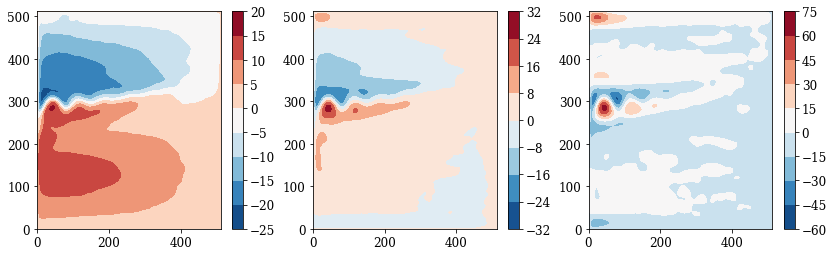

In [5]:
# load data as is, and let subroutine take care of normalisation with time-average
psi_tave = load_grid_data(data_dir, "psi_int.dat", tave=True)
psi_m = grid_to_mesh(psi_tave, 
                     [Function(space, name = "psi_m_%i" % (i + 1)) for i in range(layers)])
    
# test plot
fig = plt.figure(figsize = (14, 4))

for layer in range(layers):
    ax = plt.subplot(1, layers, layer+1)
    cs = ax.contourf(x_vec, y_vec, float(H[layer]) * psi_tave[layer, :, :] * scale * scale / 1e12)
    plt.colorbar(cs)
#del psi_tave

# noise

In [6]:
# misc subroutines

@jit(nopython=True)
def diffusion_loop(tmask, zaheeu, zaheev, e1e2t, z_in, power=2, alpha=100, diag_freq=50):
    
    npj, npi = tmask.shape
    
    ztu, ztv, zlap = np.zeros((npj, npi)), np.zeros((npj, npi)), np.zeros((npj, npi))
    z_orig, z_prev, z_now = np.zeros((npj, npi)), np.zeros((npj, npi)), np.zeros((npj, npi))
    
    # make copy of "original" field to be held fix during the iteration stage
    
    z_orig[:, :] = z_in[:, :]
    
    for n in range(power):
        z_prev[:, :] = z_orig[:, :]
        z_now[:, :] = 0.0
        
        glob_sup_res = 1e15
        jn = 0
        print("iteration at power = ", n+1)

        while (glob_sup_res > 1e-3) and (jn < 500):
            
            # compute first derivative
            for jj in range(npj-1):
                for ji in range(npi-1):
                    ztu[jj, ji] = zaheeu[jj, ji] * (z_prev[jj  , ji+1] - z_prev[jj, ji])
                    ztv[jj, ji] = zaheev[jj, ji] * (z_prev[jj+1, ji  ] - z_prev[jj, ji])

            for jj in range(1, npj-1):
                for ji in range(1, npi-1):
                    zlap[jj, ji] = (  ztu[jj, ji] - ztu[jj  , ji-1]
                                    + ztv[jj, ji] - ztv[jj-1, ji  ]
                                   ) / e1e2t[jj, ji]
        #             z_now[jj, ji] = z_orig[jj, ji] + zlap[jj, ji] * tmask[jj, ji]
                    z_now[jj, ji] = (1.0 / alpha) * z_orig[jj, ji] + (1.0 / alpha) * tmask[jj, ji] * (
                        (alpha - 1.0) * z_prev[jj, ji] +  zlap[jj, ji]
                    )
            
            # diagnostics
            glob_sup_res = np.max(np.abs(z_now - z_prev))
            
            if (jn % diag_freq == 0):
                print("  it = ", jn, " global sup res = ", glob_sup_res)
        
            # updates
            jn += 1
            z_prev[:, :] = z_now[:, :] # iteration

        # return T* of (I - nu * D2) T*(n+1) = T(n)
        z_orig[:, :] = z_now[:, :]
        
        print("  it = ", jn, " global sup res = ", glob_sup_res)
    
    return z_now

In [7]:
nu = 1

nx_f, ny_f = 512, 512
std = 0.1

# create the metrics (assume unity spacing; masking follows NEMO convention)
e1e2t = np.ones((ny_f+1, nx_f+1))
e2_e1u = np.ones((ny_f+1, nx_f+1))
e2_e1v = np.ones((ny_f+1, nx_f+1))

tmask, umask, vmask = np.ones((ny_f+1, nx_f+1)), np.ones((ny_f+1, nx_f+1)), np.ones((ny_f+1, nx_f+1))
tmask[0, :] = tmask[-1, :] = tmask[:, 0] = tmask[:, -1] = 0
umask[0, :] = umask[-1, :] = umask[:, 0] = umask[:, -2:] = 0  # ?? maybe
vmask[0, :] = vmask[-2:, :] = vmask[:, 0] = vmask[:, -1] = 0

zaheeu = nu * nu * e2_e1u * umask
zaheev = nu * nu * e2_e1v * vmask

In [8]:
noise_1 = np.random.randn(513,513)
alpha = 50  # stabilises but makes the convergence slow
noise_out1 = diffusion_loop(tmask, zaheeu, zaheev, e1e2t, noise_1, power=2, alpha=alpha)

iteration at power =  1
  it =  0  global sup res =  4.229835719854482
  it =  50  global sup res =  0.005460929001602111
  it =  87  global sup res =  0.0009987640313142698
iteration at power =  2
  it =  0  global sup res =  0.07140470643654295
  it =  50  global sup res =  0.002481365285024406
  it =  73  global sup res =  0.0009901546738153577


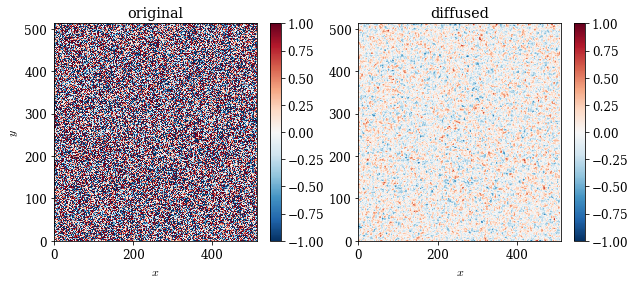

In [9]:
fig = plt.figure(figsize=(10, 4))
lm=1
ax = plt.subplot(1, 2, 1)
cs = ax.pcolormesh(noise_1, shading="auto",cmap='RdBu_r',vmax=lm,vmin=-lm)
ax.set_title(r"original")
ax.set_ylabel("$y$")
ax.set_xlabel("$x$")
plt.colorbar(cs)

ax = plt.subplot(1, 2, 2)
cs = ax.pcolormesh(noise_out1, shading="auto",cmap='RdBu_r',vmax=lm,vmin=-lm)
ax.set_title(r"diffused")
ax.set_xlabel("$x$")
plt.colorbar(cs)

In [10]:
def add_noise(origin_data,noise_level=.1):
    noise_filtered = diffusion_loop(tmask, zaheeu, zaheev, e1e2t, np.random.randn(513,513), power=2, alpha=50)

    return origin_data +  noise_level * noise_filtered *np.std(origin_data)+ np.mean(origin_data)

In [18]:
fn="empb"
fn_label="q"

ff=np.load('../data/training/uvq_%s_80.npz'%(fn))
uq_grid=ff[ff.files[0]]
vq_grid=ff[ff.files[1]]

In [16]:
noise_level=0.3

uq_noise_grid = np.zeros_like(uq_grid)
vq_noise_grid = np.zeros_like(vq_grid)

for i in range(3):
    uq_noise_grid[i] = add_noise(uq_grid[i],noise_level=noise_level)
    vq_noise_grid[i] = add_noise(vq_grid[i],noise_level=noise_level)
    
uq_noise=grid_to_mesh(uq_noise_grid,[Function(space, name = "noise_u_%i" % (i + 1)) for i in range(layers)])
vq_noise=grid_to_mesh(vq_noise_grid,[Function(space, name = "noise_v_%i" % (i + 1)) for i in range(layers)])

iteration at power =  1
  it =  0  global sup res =  3.492623517935871
  it =  50  global sup res =  0.005045190148306844
  it =  87  global sup res =  0.0009848302438077994
iteration at power =  2
  it =  0  global sup res =  0.07049553435789502
  it =  50  global sup res =  0.0023064377157152594
  it =  72  global sup res =  0.0009988354538173483
iteration at power =  1
  it =  0  global sup res =  3.823372921889345
  it =  50  global sup res =  0.005586772672562024
  it =  89  global sup res =  0.000981713088550329
iteration at power =  2
  it =  0  global sup res =  0.07466667561264373
  it =  50  global sup res =  0.0025811803916598874
  it =  74  global sup res =  0.0009711197257387116
iteration at power =  1
  it =  0  global sup res =  4.2115673648615015
  it =  50  global sup res =  0.005152625418764156
  it =  87  global sup res =  0.0009905205446733012
iteration at power =  2
  it =  0  global sup res =  0.07130987448788839
  it =  50  global sup res =  0.0023435751288090056

In [17]:
#np.savez('../data/noise_filtered/uvq_%s_%i_noise%s'%(fn,ntau,"{:02}".format(int(noise_level * 10))),uq=uq_noise_grid ,vq=vq_noise_grid )

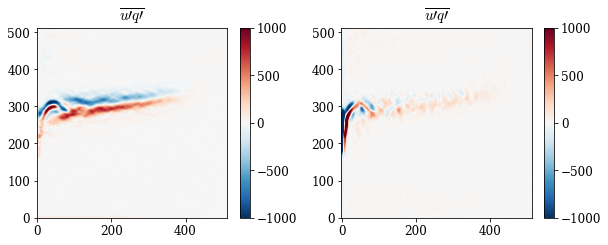

In [19]:
lm=1000

fig=plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.imshow(uq_noise_grid[0],origin='lower',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'$\overline{u\prime %s\prime}$ '%(fn_label),fontsize=15)


plt.subplot(122)
plt.imshow(vq_noise_grid[0],origin='lower',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'$\overline{u\prime %s\prime}$ '%(fn_label),fontsize=15)

In [20]:
ffd_noise = uq_c.uq_ffd(uq_noise, vq_noise, name = "ffd_noise")

computing for the appropriate eddy force functions
  at layer 1
  at layer 2
  at layer 3


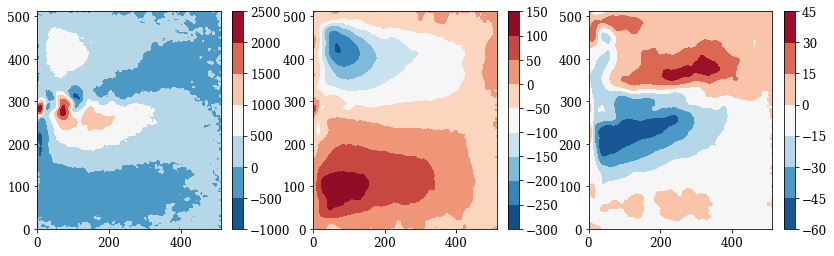

In [21]:
# integrate
fig = plt.figure(figsize = (14, 4))
for layer in range(layers):
    ax = plt.subplot(1, layers, layer+1)
    cs = ax.tricontourf(triang,ffd_noise[layer].compute_vertex_values(),origin='lower')
    plt.colorbar(cs)

In [23]:
# add noise to u'q' and v'q' to calculate eff, then grad, div 
grad_u_noise = [Function(space, name = "grad_u_%i_noise" % (i + 1)) for i in range(layers)] 
for l in range(layers): 
    L = (grad(ffd_noise[l])[0] - trial) * test * dx
    solve(lhs(L) == rhs(L), grad_u_noise[l])

grad_v_noise = [Function(space, name = "grad_v_%i_noise" % (i + 1)) for i in range(layers)] 
for l in range(layers):
    L = (grad(ffd_noise[l])[1] - trial) * test * dx
    solve(lhs(L) == rhs(L), grad_v_noise[l])

lap_eff_o = [Function(space, name = "lap_eff_o_%i_noise" % (i + 1)) for i in range(layers)] 
for l in range(layers):
    L = (div(as_vector([grad_u_noise[l], grad_v_noise[l]])) - trial) * test * dx
    solve(lhs(L) == rhs(L), lap_eff_o[l])

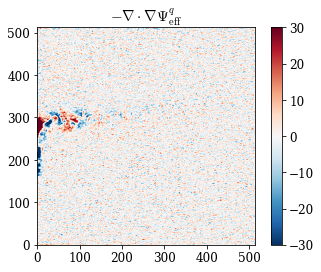

In [24]:
lm=30
plt.imshow(-mesh_to_grid(lap_eff_o)[0],origin='lower',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'$ -\nabla \cdot  \nabla  \Psi^{%s}_{\rm eff} $'%(fn_label),fontsize=15)

In [25]:
#np.savez('../data/noise_filtered/grad_%s_%i_noise%s'%(fn,ntau,"{:02}".format(int(noise_level * 10))),grad_u=mesh_to_grid(grad_u_noise),grad_v=mesh_to_grid(grad_v_noise))

In [27]:
div_uq_noise = [Function(space, name = "div_uq_noise_%i" % (i + 1)) for i in range(layers)]

for l in range(layers):  
    L = (div(as_vector([uq_noise[l], vq_noise[l]])) - trial) * test * dx
    solve(lhs(L) == rhs(L), div_uq_noise[l])
    
div_uq_noise_grid= mesh_to_grid(div_uq_noise)

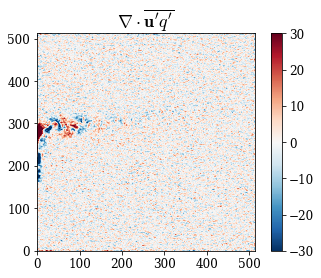

In [28]:
lm=30
plt.imshow(div_uq_noise_grid[0],origin='lower',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'$ \nabla \cdot \overline{\mathbf{u}^{\prime} %s^{\prime}} $'%(fn_label),fontsize=18)

In [29]:
#np.save('../data/noise_filtered/div_uq_%s_%i_noise%s'%(fn,ntau,"{:02}".format(int(noise_level * 10))),div_uq_noise_grid)